# 프로젝트: 번역기를 만들어보자
## 단어 단위 번역기 만들기: 영어-프랑스어

In [1]:
# 주요 라이브러리 버전 확인

import tensorflow
print(tensorflow.__version__)

2.6.0


In [2]:
# 모듈 불러오기
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import os

학습과 테스트 시의 원활한 진행을 위해서 데이터에서 상위 33,000개의 샘플만 사용하였다. <br>

33000개 중 3000개는 테스트 데이터로 분리하여 모델을 학습한 후에 번역을 테스트 하는 용도로 사용

In [3]:
file_path = os.getenv('HOME')+'/aiffel/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5) #샘플 5개 출력

전체 샘플의 수 : 197463


,eng,fra,cc
9357,Who thinks so?,Qui partage cet avis ?,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
161315,All wished each other a Merry Christmas.,Tous se sont souhaités un joyeux Noël.,CC-BY 2.0 (France) Attribution: tatoeba.org #7...
30029,I made a few calls.,J'ai passé quelques coups de fil.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
138783,What are you two conspiring about?,Qu'est-ce que vous complotez tous les deux ?,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
36877,I'm more than happy.,Je suis plus que content.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...


In [4]:
lines = lines[['eng', 'fra']][:33000] # 33,000개 샘플 사용
lines.sample(5)

,eng,fra
32461,Tom almost drowned.,Tom s'est presque noyé.
28657,Do you want to eat?,Est-ce que vous voulez manger ?
1207,I'm ready!,Je suis prête !
10499,I have a cough.,J’ai une toux.
15314,Let's try again.,Essayons encore une fois.


In [5]:
# 시작 토큰과 종료 토큰 추가
sos_token = '\t'
eos_token = '\n'
lines.fra = lines.fra.apply(lambda x : '\t '+ x + ' \n')
print('전체 샘플의 수 :',len(lines))
lines.sample(5)

전체 샘플의 수 : 33000


,eng,fra
27443,What was your job?,\t Quel était ton travail ? \n
24873,I'm really hungry.,\t J'ai vraiment faim. \n
15395,My cat is black.,\t Mon chat est noir. \n
20455,That isn't a cat.,\t Ce n'est pas un chat. \n
32753,Tom looks relieved.,\t Tom a l'air soulagé. \n


In [6]:
# 구두점 분리
# 소문자 바꾸기: 토크나이저에 내장되어있음
# 띄어쓰기: 토크나이저에 내장되어 있음

In [7]:
import string

def pad_punctuation(s): return re.sub(f"([{string.punctuation}])", r' \1 ', s)

# 프랑스어 구두점 분리
def french_punctuations(s):
    s = re.sub('[\u202f\u2009\xa0]', '', s)
    s = re.sub('’', " ' ", s)
    s = re.sub('[—––]', ' - ', s)
    s = re.sub('[«»]', ' " ', s)
    return s

# 참고: https://stackoverflow.com/questions/64125019/how-to-tokenize-punctuations-using-the-tokenizer-function-tensorflow

In [8]:
import re

lines.fra = [pad_punctuation(s) for s in lines.fra]
lines.fra[50:60]

50              \t Bonjour  !  \n
51                \t Salut  !  \n
52          \t Je comprends .  \n
53                   \t Aha .  \n
54            \t J ' essaye .  \n
55         \t J ' ai gagné  !  \n
56    \t Je l ' ai emporté  !  \n
57            \t J’ai gagné .  \n
58               \t Oh non  !  \n
59           \t Calme - toi .  \n
Name: fra, dtype: object

In [9]:
lines.fra = [french_punctuations(s) for s in lines.fra]
lines.fra[50:60]

50              \t Bonjour  !  \n
51                \t Salut  !  \n
52          \t Je comprends .  \n
53                   \t Aha .  \n
54            \t J ' essaye .  \n
55         \t J ' ai gagné  !  \n
56    \t Je l ' ai emporté  !  \n
57          \t J ' ai gagné .  \n
58               \t Oh non  !  \n
59           \t Calme - toi .  \n
Name: fra, dtype: object

In [10]:
# 구두점 분리된 영어 문장을 뽑아서 확인
lines.eng = [pad_punctuation(s) for s in lines.eng]
lines.eng.head()

0    Go . 
1    Go . 
2    Go . 
3    Go . 
4    Hi . 
Name: eng, dtype: object

영어와 프랑스어에 대한 토크나이저를 각각 생성

In [11]:
# 텍스트 시퀀스를 정수 시퀀스로 변환하는 정수 인코딩 과정
eng_tokenizer = Tokenizer(char_level=False, filters="")   # 단어 단위로 Tokenizer를 생성합니다. 
eng_tokenizer.fit_on_texts(lines.eng)               # 33,000개의 행을 가진 eng의 각 행에 토큰화를 수행
input_text = eng_tokenizer.texts_to_sequences(lines.eng)    # 단어를 숫자값 인덱스로 변환하여 저장
input_text[:3]

[[29, 1], [29, 1], [29, 1]]

In [12]:
fra_tokenizer = Tokenizer(char_level=False, filters="")   # 단어 단위로 Tokenizer를 생성합니다. 
fra_tokenizer.fit_on_texts(lines.fra)                 # 33,000개의 행을 가진 fra의 각 행에 토큰화를 수행
target_text = fra_tokenizer.texts_to_sequences(lines.fra)     # 단어를 숫자값 인덱스로 변환하여 저장
target_text[:3]

[[1, 74, 10, 2], [1, 339, 3, 2], [1, 27, 489, 10, 2]]

In [13]:
# 단어장의 크기를 변수로 저장, 0번 토큰을 고려하여 +1
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 4713
프랑스어 단어장의 크기 : 8595


In [14]:
# 패딩을 위해서 최대 길이 구하기
max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in target_text])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 시퀀스의 최대 길이 10
프랑스어 시퀀스의 최대 길이 20


In [15]:
# 전체적인 통계 정보 출력
print('전체 샘플의 수 :',len(lines))
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 33000
영어 단어장의 크기 : 4713
프랑스어 단어장의 크기 : 8595
영어 시퀀스의 최대 길이 10
프랑스어 시퀀스의 최대 길이 20


In [16]:
encoder_input = input_text

# 종료 토큰 제거
decoder_input = [[ char for char in line if char != fra_tokenizer.word_index[eos_token] ] for line in target_text] 

# 시작 토큰 제거
decoder_target = [[ char for char in line if char != fra_tokenizer.word_index[sos_token] ] for line in target_text]

In [17]:
# 디코더의 입력과 출력 확인
print(decoder_input[:3])
print(decoder_target[:3])

[[1, 74, 10], [1, 339, 3], [1, 27, 489, 10]]
[[74, 10, 2], [339, 3, 2], [27, 489, 10, 2]]


padding

In [18]:
# 모든 샘플들의 길이 동일하게 변환
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (33000, 10)
프랑스어 입력데이터의 크기(shape) : (33000, 20)
프랑스어 출력데이터의 크기(shape) : (33000, 20)


In [19]:
# 인코더의 샘플 출력해보기
print(encoder_input[0])

[29  1  0  0  0  0  0  0  0  0]


In [20]:
n_of_val = 3000    # 검증데이터 3000개로 선택

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 학습데이터의 크기(shape) : (33000, 10)
프랑스어 학습 입력데이터의 크기(shape) : (33000, 20)
프랑스어 학습 출력데이터의 크기(shape) : (33000, 20)


임베딩층 사용하기
- 입력이 되는 각 단어를 임베딩 층을 사용하여 벡터화
- 주의할 점: 인코더와 디코더의 임베딩 층은 서로 다른 임베딩 층을 사용해야 하지만,
- 디코더의 훈련 과정과 테스트 과정(예측 과정)에서의 임베딩 층은 동일해야

In [21]:
from tensorflow.keras.layers import Input, Embedding, Masking, LSTM

# 인코더에서 사용할 임베딩 층 사용
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(eng_vocab_size, 256)(encoder_inputs)
encoder_lstm = LSTM(256, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

In [22]:
from tensorflow.keras.layers import Input, Embedding, Masking

# 디코더에서 사용할 임베딩 층 사용
decoder_inputs = Input(shape=(None,))
dec_emb =  Embedding(fra_vocab_size, 256)(decoder_inputs)
decoder_lstm = LSTM(256, return_sequences = True, return_state=True)
decoder_outputs, _, _= decoder_lstm(dec_emb, initial_state = encoder_states)

글자 단위 번역기에서 구현한 모델을 참고로 단어 단위 번역기의 모델을 완성

In [23]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model

print('⏳')

⏳


In [24]:
# 디코더의 출력층
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

In [25]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")    # 원핫인코딩이 아닐 때
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 256)    1206528     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 256)    2200320     input_2[0][0]                    
______________________________________________________________________________________________

In [26]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience=4) # add early stopping

history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=256, epochs=50, callbacks=early_stopping)

Epoch 1/50
118/118 [==============================] - 10s 48ms/step - loss: 1.9352 - val_loss: 1.6235
Epoch 2/50
118/118 [==============================] - 5s 42ms/step - loss: 1.2549 - val_loss: 1.4182
Epoch 3/50
118/118 [==============================] - 5s 42ms/step - loss: 1.0640 - val_loss: 1.2812
Epoch 4/50
118/118 [==============================] - 5s 42ms/step - loss: 0.9492 - val_loss: 1.1948
Epoch 5/50
118/118 [==============================] - 5s 42ms/step - loss: 0.8650 - val_loss: 1.1161
Epoch 6/50
118/118 [==============================] - 5s 42ms/step - loss: 0.8013 - val_loss: 1.0705
Epoch 7/50
118/118 [==============================] - 5s 43ms/step - loss: 0.7509 - val_loss: 1.0501
Epoch 8/50
118/118 [==============================] - 5s 43ms/step - loss: 0.7076 - val_loss: 1.0192
Epoch 9/50
118/118 [==============================] - 5s 43ms/step - loss: 0.6683 - val_loss: 0.9942
Epoch 10/50
118/118 [==============================] - 5s 43ms/step - loss: 0.6329 - val_l

모델 평가

dict_keys(['loss', 'val_loss'])


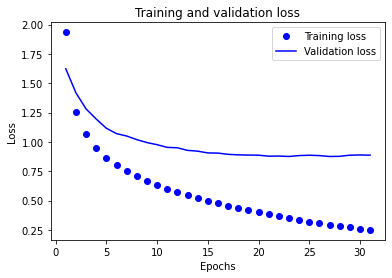

In [27]:
import matplotlib.pyplot as plt

# plot loss
history_dict = history.history
print(history_dict.keys()) # keys to check parameters for plotting

# acc = history_dict['accuracy']
# val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

# "bo" is "dotted blue"
plt.plot(epochs, loss, 'bo', label='Training loss')
# "b" is "blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [28]:
# 인코더 정의
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 256)         1206528   
_________________________________________________________________
lstm (LSTM)                  [(None, 256), (None, 256) 525312    
Total params: 1,731,840
Trainable params: 1,731,840
Non-trainable params: 0
_________________________________________________________________


In [29]:
# 디코더 설계

# 이전 time step의 hidden state를 저장하는 텐서
decoder_state_input_h = Input(shape=(256,))
# 이전 time step의 cell state를 저장하는 텐서
decoder_state_input_c = Input(shape=(256,))
# 이전 time step의 hidden state와 cell state를 하나의 변수에 저장
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# decoder_states_inputs를 현재 time step의 초기 상태로 사용.
# 구체적인 동작 자체는 def decode_sequence()에 구현.
decoder_outputs, state_h, state_c = decoder_lstm(dec_emb, initial_state = decoder_states_inputs)
# 현재 time step의 hidden state와 cell state를 하나의 변수에 저장.
decoder_states = [state_h, state_c]

In [30]:
# 디코더 출력층 재설계
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs] + decoder_states)
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 256)    2200320     input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256)]        0                                            
____________________________________________________________________________________________

In [31]:
# 단어에서 정수로, 정수에서 단어로 바꾸는 사전(dictionary) 준비
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

In [32]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # 에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1,1)) 
    target_seq[0, 0] = fra2idx['\t']
    
    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # 에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장     
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [33]:
# 임의의 샘플 입력하여 출력 결과 테스트
import numpy as np
for seq_index in [3,50,100,300,1001]: # 입력 문장의 인덱스 (자유롭게 선택해 보세요)
    input_seq = encoder_input[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', lines.eng[seq_index])
    print('정답 문장:', lines.fra[seq_index][1:len(lines.fra[seq_index])-1]) # '\t'와 '\n'을 빼고 출력
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1]) # '\n'을 빼고 출력

-----------------------------------
입력 문장: Go . 
정답 문장:  Bouge  !  
번역기가 번역한 문장:  va ! 
-----------------------------------
입력 문장: Hello ! 
정답 문장:  Bonjour  !  
번역기가 번역한 문장:  bonjour ! 
-----------------------------------
입력 문장: Got it ? 
정답 문장:  T ' as capté ?  
번역기가 번역한 문장:  cela a - t - il l ' ai
-----------------------------------
입력 문장: Hang on . 
정답 문장:  Tiens bon  !  
번역기가 번역한 문장:  attendez . 
-----------------------------------
입력 문장: Here ' s  $ 5 . 
정답 문장:  Voilà cinq dollars .  
번역기가 번역한 문장:  voici aux règles . 


<회고> <br>
영어-프랑스어 번역기를 만들어보았다
- 관련 데이터 전처리 진행
- seq2seq 모델 사용
- 번역문 생성

순으로 진행하였다.<br>

- 아직 전반적인 과정과 코드 구현에 익숙지가 않아서 꽤나 애를 먹었다. 다른 분들의 도움을 많이 받음.
- 개념을 어렴풋이 갖고 있는 것을 코드 쳐보는 것으로 많이 연습해봐야 할 것 같다는 생각이 든다.

- 번역기는 크게 정확도가 높지는 않은 것으로 보인다. 정확도를 올리기 위해 파라미터 조정이 많이 필요할 것으로 보인다.